In [350]:
import numpy as np
import pandas as pd
import datetime
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import yfinance as yf
%matplotlib inline
pd.set_option('display.max_rows', None)
pd.reset_option('display.max_rows')

In [291]:
pd.set_option('display.max_rows', None)

In [292]:
pd.reset_option('display.max_rows')

In [293]:
pd.set_option('display.max_rows', 10)

In [594]:
def get_prices_online(symbols:[], start_date, end_date):
    # Combine all the data files into a single dataframe
    combined_df = pd.DataFrame()
    # Fetch the data and save to CSV files
    for symbol in symbols:
        df = yf.download(symbol, start=start_date, end=end_date)
        df['Close'].to_csv(f'{symbol}_closing_prices.csv')
        combined_df[symbol] = df['Close']


    return combined_df

def get_prices_files(symbols:[]):#-> pd.DataFrame:
    combined_df = pd.DataFrame()
    for symbol in symbols:
        df = pd.read_csv(f'{symbol}_closing_prices.csv', index_col=0, parse_dates=True)
        combined_df[symbol] = df[symbol]
    return combined_df

def append_months_weeks_days(df) :#-> pd.DataFrame:
    # Extract month and week of the year and day of the week
    df = df.copy() # Don't affect the original dataframe
    df['Year'] = df.index.year
    df['Quarter'] = df.index.quarter
    df['Month'] = df.index.month
    df['Week'] = df.index.isocalendar().week
    df['Day'] = df.index.dayofweek
    return df

def mean_daily_return_by_week(df):
    df['Daily Return'] = df['Adj. Close'].pct_change()
    weekly_mean_return = df.groupby('Week')['Daily Return'].mean().reset_index()
    return weekly_mean_return

def log_daily_return(df):
    df_ret = np.log(df/df.shift(1))
    return df_ret

def prices_by_period(df:pd.DataFrame, period:str, num_list:[], ret_columns):
    # num == 0 for return all values
    # Num > 0 for specific value
    if num_list != []:
        df_ret = df[df[period].isin(num_list)][ret_columns]
    else:
        df_ret = df[ret_columns]
    return df_ret

def log_mean_daily_return_by_week(df):
    df['Daily Return'] = np.log(df['Adj. Close']/df['Adj. Close'].shift(1))
    log_weekly_mean_return = df.groupby('Week')['Daily Return'].sum().reset_index()
    return log_weekly_mean_return

# Extract for specific period
def extract_for_period(period:str, period_num_list:[], ret_columns:[], df:pd.DataFrame):
    df_all = append_months_weeks_days(df)
    # period_num_list == [] for return all values
    # period_num_list != [] for specific value(s)
    if period_num_list != []:
        df_ret = df_all[df_all[period].isin(period_num_list)]
    else:
        df_ret = df_all
        
    df_ret = df_ret.groupby(['Year', period])[ret_columns].sum() # Group by period
        
    # 252 days in year  12 Months in a year 4 Quarters in a year  52 weeks in a year  5 days in a week 
    if period == 'Month':
        periods_per_year = 12
    elif period == 'Quarter':
        periods_per_year = 4
    elif period == 'Week':
        periods_per_year = 52
    elif period == 'Day':
        periods_per_year = 252
    else:
        periods_per_year = 1
        
    return df_ret, periods_per_year

# Extract for specific period
def extract_mean_for_period(period:str, period_num_list:[], df:pd.DataFrame):
    log_ret_all = extract_months_weeks_days(df)
    log_ret = log_ret_all.groupby(period)[ret_columns].sum()
    df_period_n = prices_by_period(log_ret_all, period, period_num_list, price_columns)
        
    # 252 days in year  12 Months in a year 4 Quarters in a year  52 weeks in a year  5 days in a week 
    if period == 'Month':
        periods_per_year = 12
    elif period == 'Quarter':
        periods_per_year = 4
    elif period == 'Week':
        periods_per_year = 52
    elif period == 'Day':
        periods_per_year = 252
    else:
        periods_per_year = 1
        
    return df_period_n, periods_per_year



def get_ret_vol_sr(weights):
    """
    Takes in weights, returns array of return,volatility, sharpe ratio
    """
    global g_log_ret
    global g_num_periods
    weights = np.array(weights)
    ret = np.sum(g_log_ret.mean() * weights) * g_num_periods
    vol = np.sqrt(np.dot(weights.T, np.dot(g_log_ret.cov() * g_num_periods, weights)))
    sr = ret/vol
    return np.array([ret,vol,sr])

def neg_sharpe(weights):
    return  get_ret_vol_sr(weights)[2] * -1

def neg_return(weights):
    return  get_ret_vol_sr(weights)[0] * -1

# Constraints
def check_sum(weights):
    '''
    Returns 0 if sum of weights is 1.0
    '''
    return np.sum(weights) - 1

def minimize_volatility(weights):
    return  get_ret_vol_sr(weights)[1] 

def get_max_return():
    # By convention of minimize function it should be a function that returns zero for conditions
    cons = ({'type':'eq','fun': check_sum})
    # 0-1 bounds for each weight
    bounds = tuple((0, 1) for _ in range(num_stocks))

    # Initial Guess (equal distribution)
    init_guess = [1/num_stocks for _ in range(num_stocks)]
    # Get max possible return to give limits for the efficient frontier calculation
    opt_results = minimize(fun=neg_return,x0=init_guess,method='SLSQP',bounds=bounds,constraints=cons)

    max_return = get_ret_vol_sr(opt_results.x)[0]
    return max_return

def get_max_sharp_portfolio():
    # By convention of minimize function it should be a function that returns zero for conditions
    cons = ({'type':'eq','fun': check_sum})
    # 0-1 bounds for each weight
    bounds = tuple((0, 1) for _ in range(num_stocks))

    # Initial Guess (equal distribution)
    init_guess = [1/num_stocks for _ in range(num_stocks)]
    # Get max Sharp Ratio
    opt_results = minimize(fun=neg_sharpe,x0=init_guess,method='SLSQP',bounds=bounds,constraints=cons)

    portfolio = (opt_results.x)
    return portfolio, opt_results.fun

def get_min_volatility_portfolio():
    # By convention of minimize function it should be a function that returns zero for conditions
    cons = ({'type':'eq','fun': check_sum})
    # 0-1 bounds for each weight
    bounds = tuple((0, 1) for _ in range(num_stocks))

    # Initial Guess (equal distribution)
    init_guess = [1/num_stocks for _ in range(num_stocks)]
    # Get min volatility
    opt_results = minimize(fun=minimize_volatility,x0=init_guess,method='SLSQP',bounds=bounds,constraints=cons)

    portfolio = (opt_results.x)
    return portfolio

def decode_ret_vol_sr(df_portfolio):
    list_set = get_ret_vol_sr(df_portfolio)
    ret_val = list_set[0]
    vol_val = list_set[1]
    sr_val = list_set[2]
    return ret_val, vol_val, sr_val

def get_efficient_frontier():
    max_return = get_max_return()
    # Our returns go from 0 to somewhere along 0.3
    # Create a linspace number of points to calculate x on
    frontier_y = np.linspace(0,max_return,100) # Change 100 to a lower number for slower computers!
    frontier_volatility = []
    portfolios = []

    for possible_return in frontier_y:
        # function for return
        cons = ({'type':'eq','fun': check_sum},
                {'type':'eq','fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
        
        result = minimize(minimize_volatility,init_guess,method='SLSQP',bounds=bounds,constraints=cons)
        
        portfolios.append([result['x'], possible_return, result['fun']])
    df_ret = pd.DataFrame(portfolios, columns=['Weights', 'Return', 'Volatility'])
    return df_ret

def plot_efficient_frontier():
    max_return = get_max_return()
    min_volatility = get_min_volatility_portfolio()
    df_portfolio, max_sharp = get_max_sharp_portfolio()
    ret_val, vol_val, sr_val = decode_ret_vol_sr(df_portfolio)
    plt.figure(figsize=(12,8))
    plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
    plt.colorbar(label='Sharpe Ratio')
    plt.xlabel('Volatility')
    plt.ylabel('Return')

    # Add red dot for max SR
    plt.scatter(vol_val,ret_val,c='red',s=50,edgecolors='black')
    print('Max. Sharp Ratio: ',max_sr_ret, ' Ret:', ret_val, ' Vol: ', vol_val, ' weights: ',all_weights[max_sharp_arg])

    # Add frontier line
    plt.plot(frontier_volatility,frontier_y,'g--',linewidth=3)
    plt.show()

In [595]:
# Define the list of stock symbols
symbols = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']
start_date = '2010-01-01'
end_date = '2024-12-31'

df_prices = get_prices_files(symbols)

price_columns = df_prices.columns
stocks = df_prices
stocks.columns = price_columns
num_stocks = len(price_columns)

print(stocks)

                  AAPL        MSFT       GOOGL        AMZN        TSLA
Date                                                                  
2010-01-04    6.447412   23.300680   15.627781    6.695000         NaN
2010-01-05    6.458559   23.308203   15.558962    6.734500         NaN
2010-01-06    6.355827   23.165165   15.166740    6.612500         NaN
2010-01-07    6.344077   22.924252   14.813666    6.500000         NaN
2010-01-08    6.386254   23.082352   15.011148    6.676000         NaN
...                ...         ...         ...         ...         ...
2024-12-23  255.270004  435.250000  194.630005  225.059998  430.600006
2024-12-24  258.200012  439.329987  196.110001  229.050003  462.279999
2024-12-26  259.019989  438.109985  195.600006  227.050003  454.130005
2024-12-27  255.589996  430.529999  192.759995  223.750000  431.660004
2024-12-30  252.199997  424.829987  191.240005  221.300003  417.410004

[3773 rows x 5 columns]


In [385]:
num_stocks

5

In [295]:
# Download and get Daily Returns
head = 'course/09-Python-Finance-Fundamentals/'
aapl = pd.read_csv(head + 'AAPL_CLOSE',index_col='Date',parse_dates=['Date'])
cisco = pd.read_csv(head + 'CISCO_CLOSE',index_col='Date',parse_dates=['Date'])
ibm = pd.read_csv(head + 'IBM_CLOSE',index_col='Date',parse_dates=['Date'])
amzn = pd.read_csv(head + 'AMZN_CLOSE',index_col='Date',parse_dates=['Date'])
price_columns = ['aapl','cisco','ibm','amzn']
stocks = pd.concat([aapl['Adj. Close'],cisco['Adj. Close'],ibm['Adj. Close'],amzn['Adj. Close']],axis=1)
stocks.columns = price_columns

In [360]:
num_stocks = len(price_columns)
mean_daily_ret = stocks.pct_change(1).mean()
mean_daily_ret
stocks.pct_change(1).corr()

,AAPL,MSFT,GOOGL,AMZN,TSLA
AAPL,1.000000,0.588407,0.546543,0.478499,0.354915
MSFT,0.588407,1.000000,0.635512,0.570318,0.347066
GOOGL,0.546543,0.635512,1.000000,0.595467,0.328449
AMZN,0.478499,0.570318,0.595467,1.000000,0.349555
TSLA,0.354915,0.347066,0.328449,0.349555,1.000000


In [361]:
mean_daily_ret

AAPL     0.001127
MSFT     0.000900
GOOGL    0.000812
AMZN     0.001140
TSLA     0.002176
dtype: float64

<Axes: xlabel='Date'>

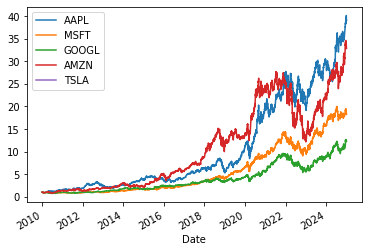

In [363]:
stock_normed = stocks/stocks.iloc[1]
stock_normed.plot()

In [364]:
stock_daily_ret = stocks.pct_change(1)
stock_daily_ret.head()

,AAPL,MSFT,GOOGL,AMZN,TSLA
Date,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN
2010-01-05,0.001729,0.000323,-0.004404,0.005900,NaN
2010-01-06,-0.015906,-0.006137,-0.025209,-0.018116,NaN
2010-01-07,-0.001849,-0.010400,-0.023279,-0.017013,NaN
2010-01-08,0.006648,0.006897,0.013331,0.027077,NaN


In [365]:
log_stocks_ret = log_daily_return(stocks)
log_stocks_ret.head()

,AAPL,MSFT,GOOGL,AMZN,TSLA
Date,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN
2010-01-05,0.001727,0.000323,-0.004413,0.005883,NaN
2010-01-06,-0.016034,-0.006156,-0.025532,-0.018282,NaN
2010-01-07,-0.001850,-0.010454,-0.023555,-0.017160,NaN
2010-01-08,0.006626,0.006873,0.013243,0.026717,NaN


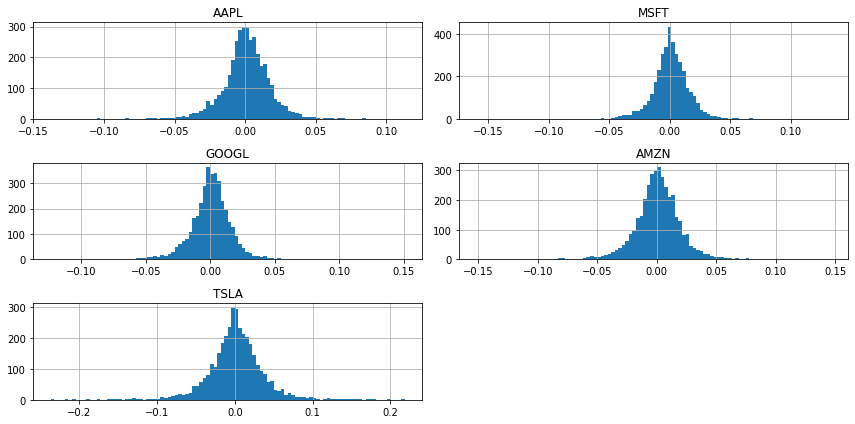

In [366]:
log_stocks_ret.hist(bins=100,figsize=(12,6));
plt.tight_layout()

In [367]:
log_stocks_ret.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
AAPL,3772.0,0.000972,0.017561,-0.137708,-0.007428,0.001004,0.010303,0.113157
MSFT,3772.0,0.000770,0.016113,-0.159454,-0.007106,0.000696,0.009196,0.132929
GOOGL,3772.0,0.000664,0.017175,-0.123685,-0.007384,0.000860,0.009218,0.150645
AMZN,3772.0,0.000927,0.020572,-0.151398,-0.009073,0.000948,0.011839,0.146225
TSLA,3650.0,0.001526,0.035986,-0.236518,-0.016264,0.001256,0.019230,0.218292


In [368]:
log_stocks_ret.mean() * 252     # Mean daily return over whole period multiplied by days per year to get mean annual return

AAPL     0.244955
MSFT     0.193958
GOOGL    0.167319
AMZN     0.233705
TSLA     0.384466
dtype: float64

In [369]:
# Compute pairwise covariance of columns
log_stocks_ret.cov()

,AAPL,MSFT,GOOGL,AMZN,TSLA
AAPL,0.000308,0.000167,0.000166,0.000173,0.000226
MSFT,0.000167,0.000260,0.000177,0.000189,0.000205
GOOGL,0.000166,0.000177,0.000295,0.000211,0.000206
AMZN,0.000173,0.000189,0.000211,0.000423,0.000261
TSLA,0.000226,0.000205,0.000206,0.000261,0.001295


In [370]:
log_stocks_ret.cov() * 252   # multiply by days in a year

,AAPL,MSFT,GOOGL,AMZN,TSLA
AAPL,0.077710,0.042074,0.041781,0.043696,0.057023
MSFT,0.042074,0.065427,0.044548,0.047654,0.051574
GOOGL,0.041781,0.044548,0.074336,0.053269,0.052015
AMZN,0.043696,0.047654,0.053269,0.106650,0.065783
TSLA,0.057023,0.051574,0.052015,0.065783,0.326336


In [371]:
log_ret = log_stocks_ret.copy()
log_ret.head()

,AAPL,MSFT,GOOGL,AMZN,TSLA
Date,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN
2010-01-05,0.001727,0.000323,-0.004413,0.005883,NaN
2010-01-06,-0.016034,-0.006156,-0.025532,-0.018282,NaN
2010-01-07,-0.001850,-0.010454,-0.023555,-0.017160,NaN
2010-01-08,0.006626,0.006873,0.013243,0.026717,NaN


## Single Run for Some Random Allocation

NOTE: Need to work out what needs doing - group by period and take mean or sum? Multiply by 5 or 52 for week, 12 or 30 for month? Multiply up to make return for the period being examined?
e.g. return per day * 252 = return for a year

In [391]:
# Set seed (optional)
np.random.seed(101)

# Stock Columns
print('Stocks')
print(stocks.columns)
print('\n')

# Create Random Weights
print('Creating Random Weights')
weights = np.array(np.random.random(num_stocks))
print(weights)
print('\n')

# Rebalance Weights
print('Rebalance to sum to 1.0')
weights = weights / np.sum(weights)
print(weights)
print('\n')

# Expected Return
print('Expected Portfolio Return')
exp_ret = np.sum(log_ret.mean() * weights) * 252
print(exp_ret)
print('\n')

# Expected Variance
print('Expected Volatility')
exp_vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
print(exp_vol)
print('\n')

# Sharpe Ratio
SR = exp_ret/exp_vol
print('Sharpe Ratio')
print(SR)


Stocks
Index(['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA'], dtype='object')


Creating Random Weights
[0.51639863 0.57066759 0.02847423 0.17152166 0.68527698]


Rebalance to sum to 1.0
[0.26182041 0.28933544 0.01443678 0.08696357 0.3474438 ]


Expected Portfolio Return
0.2765727620362649


Expected Volatility
0.29638788330969806


Sharpe Ratio
0.9331446311092003


In [390]:
type(num_stocks)

int

In [393]:
log_stocks_ret

,AAPL,MSFT,GOOGL,AMZN,TSLA
Date,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN
2010-01-05,0.001727,0.000323,-0.004413,0.005883,NaN
2010-01-06,-0.016034,-0.006156,-0.025532,-0.018282,NaN
2010-01-07,-0.001850,-0.010454,-0.023555,-0.017160,NaN
2010-01-08,0.006626,0.006873,0.013243,0.026717,NaN
...,...,...,...,...,...
2024-12-23,0.003060,-0.003097,0.016683,0.000622,0.022404
2024-12-24,0.011413,0.009330,0.007575,0.017573,0.070991
2024-12-26,0.003171,-0.002781,-0.002604,-0.008770,-0.017787


In [310]:
period = 'Month'
period_num_list = [3]
df = log_stocks_ret.copy()  # Extract for specific period  
log_ret_all = append_months_weeks_days(df)     # Append period values to the dataframe
log_ret_all = log_ret_all[log_ret_all[period].isin(period_num_list)]
log_ret = log_ret_all.groupby(['Year',period])[price_columns].sum()  # Group by period
#df_period_n = prices_by_period(df, period, period_num_list, price_columns) # Extract for specific periods
        

In [394]:

log_ret=log_stocks_ret.copy()
num_periods_in_year = 252

# Select a new period

In [431]:

log_ret, num_periods_in_year = extract_for_period('Month',[1], price_columns, log_stocks_ret)

In [432]:
g_log_ret = log_ret
g_num_periods = num_periods_in_year
print(g_log_ret, g_num_periods)

                AAPL      MSFT     GOOGL      AMZN      TSLA
Year Month                                                  
2010 1     -0.108215 -0.093760 -0.167784 -0.065505  0.000000
2011 1      0.050655 -0.006470  0.010701 -0.059278 -0.099826
2012 1      0.119658  0.128850 -0.107427  0.116254  0.017700
2013 1     -0.155589  0.027328  0.066063  0.056680  0.102078
2014 1     -0.113949  0.011429  0.052374 -0.105977  0.187262
2015 1      0.059612 -0.139546  0.012900  0.133092 -0.088365
2016 1     -0.078224 -0.007054 -0.021646 -0.141005 -0.227361
2017 1      0.046642  0.039598  0.034406  0.093639  0.164625
2018 1     -0.010693  0.104998  0.115371  0.215627  0.129255
2019 1      0.053687  0.027769  0.074595  0.134808 -0.080629
2020 1      0.052602  0.076456  0.067402  0.083480  0.441578
2021 1     -0.005516  0.041998  0.041749 -0.015699  0.117344
2022 1     -0.015837 -0.078334 -0.068192 -0.108510 -0.120597
2023 1      0.104829  0.032774  0.113555  0.205174  0.340916
2024 1     -0.043145  0.

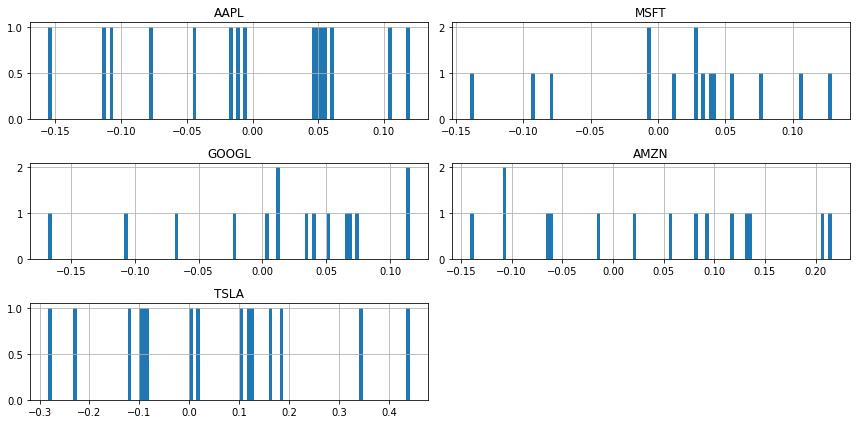

In [433]:


log_ret.hist(bins=100,figsize=(12,6))

plt.tight_layout()



In [451]:
num_ports = 30000

all_weights = np.zeros((num_ports,len(stocks.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for ind in range(num_ports):

    # Create Random Weights
    weights = np.array(np.random.random(num_stocks))

    # Rebalance Weights
    weights = weights / np.sum(weights)
    
    # Save Weights
    all_weights[ind,:] = weights

    # Expected Return
    ret_arr[ind] = np.sum((log_ret.mean() * weights) * num_periods_in_year)

    # Expected Variance
    vol_arr[ind] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * num_periods_in_year, weights)))

    # Sharpe Ratio
    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]

In [452]:
sharpe_arr.max()
max_sharp_arg = sharpe_arr.argmax() # The location in the array of the max sharp value
all_weights[max_sharp_arg,:]
max_sr_ret = ret_arr[max_sharp_arg]
max_sr_vol = vol_arr[max_sharp_arg]


In [453]:
sharpe_arr.max()
max_sharp_arg

np.int64(15162)

0.3244769193577363 0.3786036084907427 Ret: 0.3786036084907427  weights:  [0.0054084  0.20996531 0.055252   0.64841021 0.08096409]


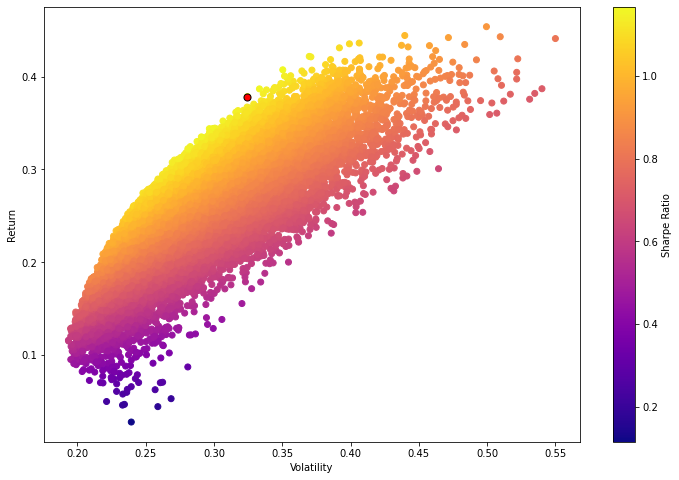

In [454]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

# Add red dot for max SR
plt.scatter(max_sr_vol,max_sr_ret,c='red',s=50,edgecolors='black')
print(max_sr_vol,max_sr_ret, 'Ret:', ret_arr[max_sharp_arg], ' weights: ',all_weights[max_sharp_arg])

In [455]:

g_log_ret = log_ret
g_num_periods = num_periods_in_year
#g_num_periods = 252

Max. Sharp Ratio:  0.3786036084907427  Ret: 0.3802448392247604  Vol:  0.3242564805332534  weights:  [0.0054084  0.20996531 0.055252   0.64841021 0.08096409]


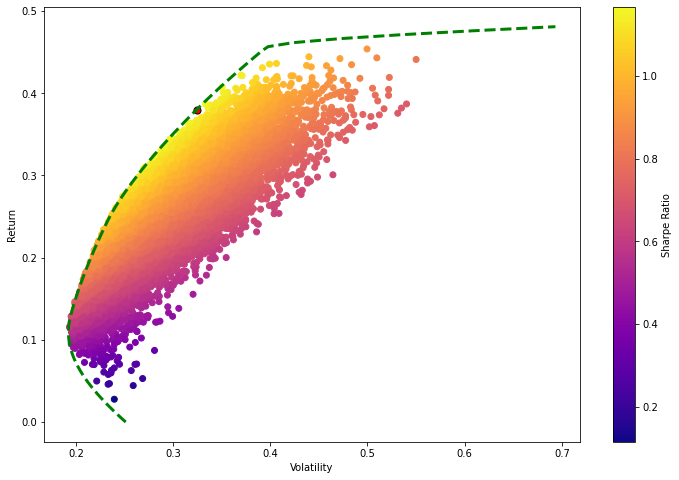

In [593]:
    max_return = get_max_return()
    min_volatility = get_min_volatility_portfolio()
    df_portfolio, max_sharp = get_max_sharp_portfolio()
    plot_efficient_frontier()

In [538]:
get_min_volatility_portfolio()

array([3.25511554e-01, 3.60991981e-01, 3.13496465e-01, 0.00000000e+00,
       3.17671237e-17])

In [536]:
opt_results

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.19217469213296456
       x: [ 3.255e-01  3.610e-01  3.135e-01  0.000e+00  3.177e-17]
     nit: 5
     jac: [ 1.921e-01  1.924e-01  1.921e-01  2.832e-01  3.349e-01]
    nfev: 30
    njev: 5

In [586]:
df = get_efficient_frontier()
df

,Weights,Return,Volatility
0,"[0.8384458419584598, 0.0404816828753939, 0.121...",0.000000,0.251157
1,"[0.8157156849850496, 0.054660186298356325, 0.1...",0.004859,0.246601
2,"[0.7929855400830461, 0.06883806902779957, 0.13...",0.009718,0.242172
3,"[0.7702554068129164, 0.08301535513984393, 0.14...",0.014576,0.237876
4,"[0.7475252837498032, 0.09719211645474599, 0.15...",0.019435,0.233722
...,...,...,...
95,"[1.292954413950644e-16, 0.0, 0.0, 0.6519295928...",0.461584,0.423499
96,"[2.498001805406602e-16, 0.0, 0.0, 0.4889471848...",0.466443,0.471386
97,"[1.6653345369377348e-15, 0.0, 0.0, 0.325964803...",0.471302,0.535471
98,"[3.4416913763379853e-15, 0.0, 0.0, 0.162982422...",0.476161,0.610676


In [585]:
plot_efficient_frontier()

ValueError: operands could not be broadcast together with shapes (5,) (3,) 

In [569]:
df = get_efficient_frontier()
frontier_y = df['Return']
frontier_volatility = df['Volatility']

In [573]:

df

,Weights,Return,Volatility
0,"[0.8384458419584598, 0.0404816828753939, 0.121...",0.000000,0.251157
1,"[0.8157156849850496, 0.054660186298356325, 0.1...",0.004859,0.246601
2,"[0.7929855400830461, 0.06883806902779957, 0.13...",0.009718,0.242172
3,"[0.7702554068129164, 0.08301535513984393, 0.14...",0.014576,0.237876
4,"[0.7475252837498032, 0.09719211645474599, 0.15...",0.019435,0.233722
...,...,...,...
95,"[1.292954413950644e-16, 0.0, 0.0, 0.6519295928...",0.461584,0.423499
96,"[2.498001805406602e-16, 0.0, 0.0, 0.4889471848...",0.466443,0.471386
97,"[1.6653345369377348e-15, 0.0, 0.0, 0.325964803...",0.471302,0.535471
98,"[3.4416913763379853e-15, 0.0, 0.0, 0.162982422...",0.476161,0.610676


In [574]:
df['Weights'][1][0]

np.float64(0.8157156849850496)

# All Optimal Portfolios (Efficient Frontier)

The efficient frontier is the set of optimal portfolios that offers the highest expected return for a defined level of risk or the lowest risk for a given level of expected return. Portfolios that lie below the efficient frontier are sub-optimal, because they do not provide enough return for the level of risk. Portfolios that cluster to the right of the efficient frontier are also sub-optimal, because they have a higher level of risk for the defined rate of return.

Efficient Frontier http://www.investopedia.com/terms/e/efficientfrontier

0.3244769193577363 0.3786036084907427 Ret: 0.3786036084907427  weights:  [0.0054084  0.20996531 0.055252   0.64841021 0.08096409]


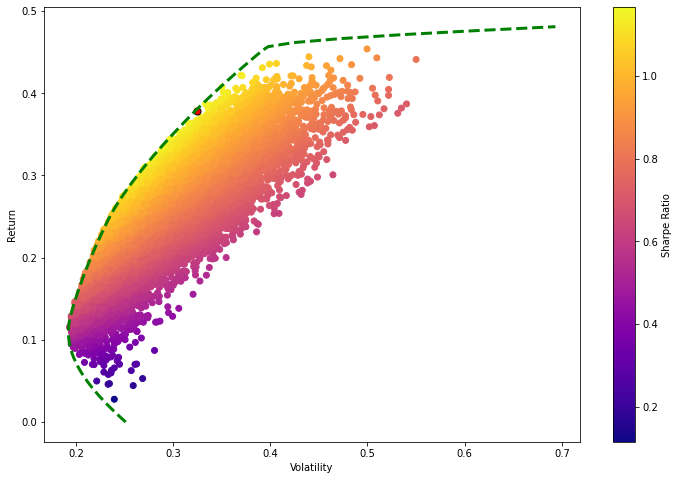

In [567]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

# Add red dot for max SR
plt.scatter(max_sr_vol,max_sr_ret,c='red',s=50,edgecolors='black')
print(max_sr_vol,max_sr_ret, 'Ret:', ret_arr[max_sharp_arg], ' weights: ',all_weights[max_sharp_arg])

# Add frontier line
plt.plot(frontier_volatility,frontier_y,'g--',linewidth=3)

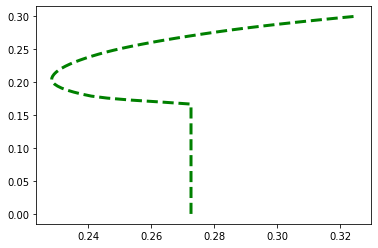

In [421]:
plt.plot(frontier_volatility,frontier_y,'g--',linewidth=3)